In [35]:
import pandas as pd
import numpy as np

import itertools
from gensim.models import Word2Vec
import nltk
from sklearn.decomposition import PCA
from matplotlib import pyplot

from utils import description_to_words, clean_accents

#### Cargamos y visualizamos el dataset

In [36]:
samples = pd.read_csv('datasets/comida_dataset.csv')
samples.head()

,section_name,category_name,category_tag_name,product_name,product_description
0,Promociones,Chivitos,Canadiense al plato,Chivito canadiense al plato para 2 con gramajo,"2 churrascos de lomo con jamón, muzza, panceta..."
1,Combinados de sushi,Sushi,sushi,Combinado Magnum - 30 piezas variadas,"Variedad de rolls, nigiris y sashimis."
2,Cucuruchos,Helados,cucurucho,Cucurucho natural,NaN
3,Sugerencia del día,Pescados y Mariscos,Merluza,Sugerencia - Merluza fresca con papas,NaN
4,Almuerzos por $99,Comida Árabe,Shawarma,Almuerzos por $99 - Shawarma Vegetariano,"Precio Anterior: $200, Ahora: $99."


In [37]:
samples.shape 

(99396, 5)

#### Rellenamos blancos con caracter nulo

In [38]:
samples["section_name"].fillna("", inplace = True)
samples["category_tag_name"].fillna("", inplace = True)
samples["product_name"].fillna("", inplace = True) 
samples["product_description"].fillna("", inplace = True)

#### Nos quedamos con los que se relacionan a nuestro producto:

In [39]:
our_target_words = '"' + '|'.join(['hamburguesa', 'Hamburguesa', 'burger', 'Burger', 'sanguche', 'Sanguche', 'sándwich', 'Sándwich']) + '|\+"'
indexNames = samples[samples["product_name"].str.contains(our_target_words)].index

In [40]:
len(indexNames)

7173

In [41]:
samples = samples.iloc[indexNames]
samples.head()

,section_name,category_name,category_tag_name,product_name,product_description
33,Hamburguesas vegetarianas,Comida Vegetariana,hamburguesa vegetariana,Hamburguesa vegetariana ciser,"Hamburguesa de garbanzos y vegetales, Lechuga,..."
66,Vegetarianas burger,Comida Vegetariana,Vegetariana,Godiee burger,"200 g de carne de lentejas al pan con rúcula, ..."
91,Hamburguesas caseras,Comida Vegetariana,hamburguesa vegetariana,Hamburguesa vegetariana,"Doble hamburguesa de lentejas y verduras,cebol..."
181,Hamburguesas,Comida Vegetariana,hamburguesa vegetariana,Hamburguesa vegetariana,"Pan artesanal con sésamo, hamburguesa de espin..."
258,Los de siempre,Comida Vegetariana,hamburguesa vegetariana,Hamburguesa Vegetariana en pan batta,"Dos hamburguesas, con mayonesa, lechuga, tomat..."


### Preprocesamiento

#### Generamos una nueva columna con la información contenido por el nombre del producto y su descripción

In [42]:
samples["description"] = samples["product_name"] + ' ' + samples["product_description"]
samples

,section_name,category_name,category_tag_name,product_name,product_description,description
33,Hamburguesas vegetarianas,Comida Vegetariana,hamburguesa vegetariana,Hamburguesa vegetariana ciser,"Hamburguesa de garbanzos y vegetales, Lechuga,...",Hamburguesa vegetariana ciser Hamburguesa de g...
66,Vegetarianas burger,Comida Vegetariana,Vegetariana,Godiee burger,"200 g de carne de lentejas al pan con rúcula, ...",Godiee burger 200 g de carne de lentejas al pa...
91,Hamburguesas caseras,Comida Vegetariana,hamburguesa vegetariana,Hamburguesa vegetariana,"Doble hamburguesa de lentejas y verduras,cebol...",Hamburguesa vegetariana Doble hamburguesa de l...
181,Hamburguesas,Comida Vegetariana,hamburguesa vegetariana,Hamburguesa vegetariana,"Pan artesanal con sésamo, hamburguesa de espin...",Hamburguesa vegetariana Pan artesanal con sésa...
258,Los de siempre,Comida Vegetariana,hamburguesa vegetariana,Hamburguesa Vegetariana en pan batta,"Dos hamburguesas, con mayonesa, lechuga, tomat...",Hamburguesa Vegetariana en pan batta Dos hambu...
...,...,...,...,...,...,...
97882,Nuestras hamburguesas caseras (300 g),Hamburguesas,Hamburguesa,Jesse Pinkman Burger,"Medallón de 300 g de carne, mayonesa, lechuga,...",Jesse Pinkman Burger Medallón de 300 g de carn...
97884,Hamburguesas,Hamburguesas,Hamburguesa,Hamburguesa doble,Doble carne casera huevo frito papá fritas jam...,Hamburguesa doble Doble carne casera huevo fri...
97885,Hamburguesas,Hamburguesas,Hamburguesa,Burger bacon,"Pan brioche, 180 gr de carne, tomate, huevo, b...","Burger bacon Pan brioche, 180 gr de carne, tom..."
97886,Hamburguesas,Hamburguesas,Hamburguesa,Hamburguesa king size,"Doble burger, doble cheddar, cebolla colorada ...","Hamburguesa king size Doble burger, doble ched..."


#### Limpiamos caracteres

In [43]:
samples['description'] = samples['description'].apply(description_to_words)
samples['description']

33       hamburguesa vegetariana ciser hamburguesa garb...
66       godiee burger g carne lentejas pan rucula alba...
91       hamburguesa vegetariana doble hamburguesa lent...
181      hamburguesa vegetariana pan artesanal sesamo h...
258      hamburguesa vegetariana pan batta dos hamburgu...
                               ...                        
97882    jesse pinkman burger medallon g carne mayonesa...
97884    hamburguesa doble doble carne casera huevo fri...
97885    burger bacon pan brioche gr carne tomate huevo...
97886    hamburguesa king size doble burger doble chedd...
97888    hamburguesa plato dos hamburguesas cebolla hue...
Name: description, Length: 7173, dtype: object

In [44]:
sentences = list(samples['description'])

for i in range(len(sentences)):
    sentences[i] = sentences[i].split()

#### Ejemplo de producto tokenizado:

In [45]:
print(sentences[1])

['godiee', 'burger', 'g', 'carne', 'lentejas', 'pan', 'rucula', 'albahaca', 'brotes', 'soja', 'cheddar', 'guarnicion', 'eleccion']


In [46]:
model = Word2Vec(sentences)

In [47]:
words = list(model.wv.vocab)
words

['hamburguesa',
 'vegetariana',
 'garbanzos',
 'vegetales',
 'lechuga',
 'tomate',
 'cebolla',
 'queso',
 'cheddar',
 'pepinillos',
 'aderezo',
 'ajo',
 'perejil',
 'burger',
 'g',
 'carne',
 'lentejas',
 'pan',
 'rucula',
 'albahaca',
 'brotes',
 'soja',
 'guarnicion',
 'eleccion',
 'doble',
 'verduras',
 'grillada',
 'artesanal',
 'sesamo',
 'espinaca',
 'morada',
 'batta',
 'dos',
 'hamburguesas',
 'mayonesa',
 'acompañada',
 'papas',
 'fritas',
 'quinoa',
 'cheeseburger',
 'ingredientes',
 'sandwiche',
 'rustico',
 'cm',
 'jamon',
 'panceta',
 'sandwiches',
 'mozzarella',
 'plancha',
 'huevo',
 'ketchup',
 'tortuga',
 'especial',
 'combo',
 'chivito',
 'comun',
 'colorada',
 'salsa',
 'calabaza',
 'zapallito',
 'aceituna',
 'morron',
 'duro',
 'vegetariano',
 'green',
 'colchon',
 'muzzarella',
 'helado',
 'sandwich',
 'jugo',
 'verde',
 'bebida',
 'anana',
 'double',
 'vacuna',
 'cerdo',
 'mostaza',
 'antigua',
 'canadiense',
 'hecha',
 'casero',
 'mejor',
 'premium',
 'aceitunas'

In [48]:
print(model['carne'])

[ 0.23407574  0.20468526 -0.30078694  0.1978944  -0.26800153  0.1254564
 -0.26101953 -0.11697568  0.23249048  0.29062223  0.24456614 -0.15112378
  0.163603   -0.09174615  0.44197628  0.59436554  0.00326403  0.02718743
  0.20397031 -0.22450536 -0.17354497  0.6888051   0.25760442  0.01505206
  0.17648245  0.0567556   0.07448687  0.06281215 -0.31329295  0.3681794
  0.5049874  -0.48667482 -0.34435233  0.19621855  0.05601117  0.45623353
 -0.13496393 -0.45155132  0.05877463 -0.06300475 -0.03097836 -0.53147644
 -0.7033094  -0.23899506  0.10795964 -0.28595442 -0.04833187 -0.00778397
 -0.06865223  0.02416977 -0.05226747 -0.03009095 -0.13022366  0.44947878
  0.00181292  0.14035742  0.28461143  0.34289572  0.29930997  0.14661597
  0.16355824 -0.24434985  0.2679442  -0.08219242  0.6132162  -0.04739163
 -0.25151122 -0.25867105  0.06242712  0.44994044 -0.17511982  0.391032
  0.6057689  -0.04988698  0.28481176 -0.10900446  0.07334633 -0.09491133
 -0.20884404  0.3283982  -0.368811    0.11733524 -0.472

/Users/leandro/Documents/facultad/analisis_datos/analisis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [49]:
print(model['lentejas'])

[ 0.02502052 -0.07798123 -0.22306576  0.07307972 -0.24172091  0.01119588
  0.25364837 -0.02758253  0.46858397  0.17319861  0.2895104   0.04215632
 -0.2673282  -0.12631798  0.26802343  0.5034945  -0.07219649  0.14108679
  0.1493224  -0.15539052 -0.13432911  0.32184368  0.13833272 -0.01699642
  0.2439078  -0.01370777  0.15493314  0.08799037 -0.15976791  0.42511722
  0.39235768 -0.33062285 -0.4263632   0.4501401  -0.04075824  0.4463346
 -0.47503215 -0.18131481 -0.00707161  0.15055132 -0.1394427  -0.6026815
 -0.6515363  -0.2604498   0.11881562 -0.26284426  0.0961502   0.2507384
  0.11329865  0.4015861  -0.16055484 -0.07153151 -0.1644792   0.17651027
 -0.00269234 -0.20860393  0.29059616  0.5225298   0.25782678 -0.14814971
  0.31203794 -0.3966845   0.30783868 -0.13377494  0.41453087 -0.26740676
 -0.21793267 -0.09881303 -0.11792001  0.4411138  -0.358737    0.1746322
  0.29581833 -0.09294667  0.07516479 -0.10794715  0.13177368 -0.20252647
  0.08679964  0.08397277 -0.22677371  0.3444057  -0.468

/Users/leandro/Documents/facultad/analisis_datos/analisis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [50]:
model.save('word2vec_example.bin')

In [51]:
new_model = Word2Vec.load('word2vec_example.bin')

In [52]:
print(new_model)

Word2Vec(vocab=712, size=100, alpha=0.025)


/Users/leandro/Documents/facultad/analisis_datos/analisis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


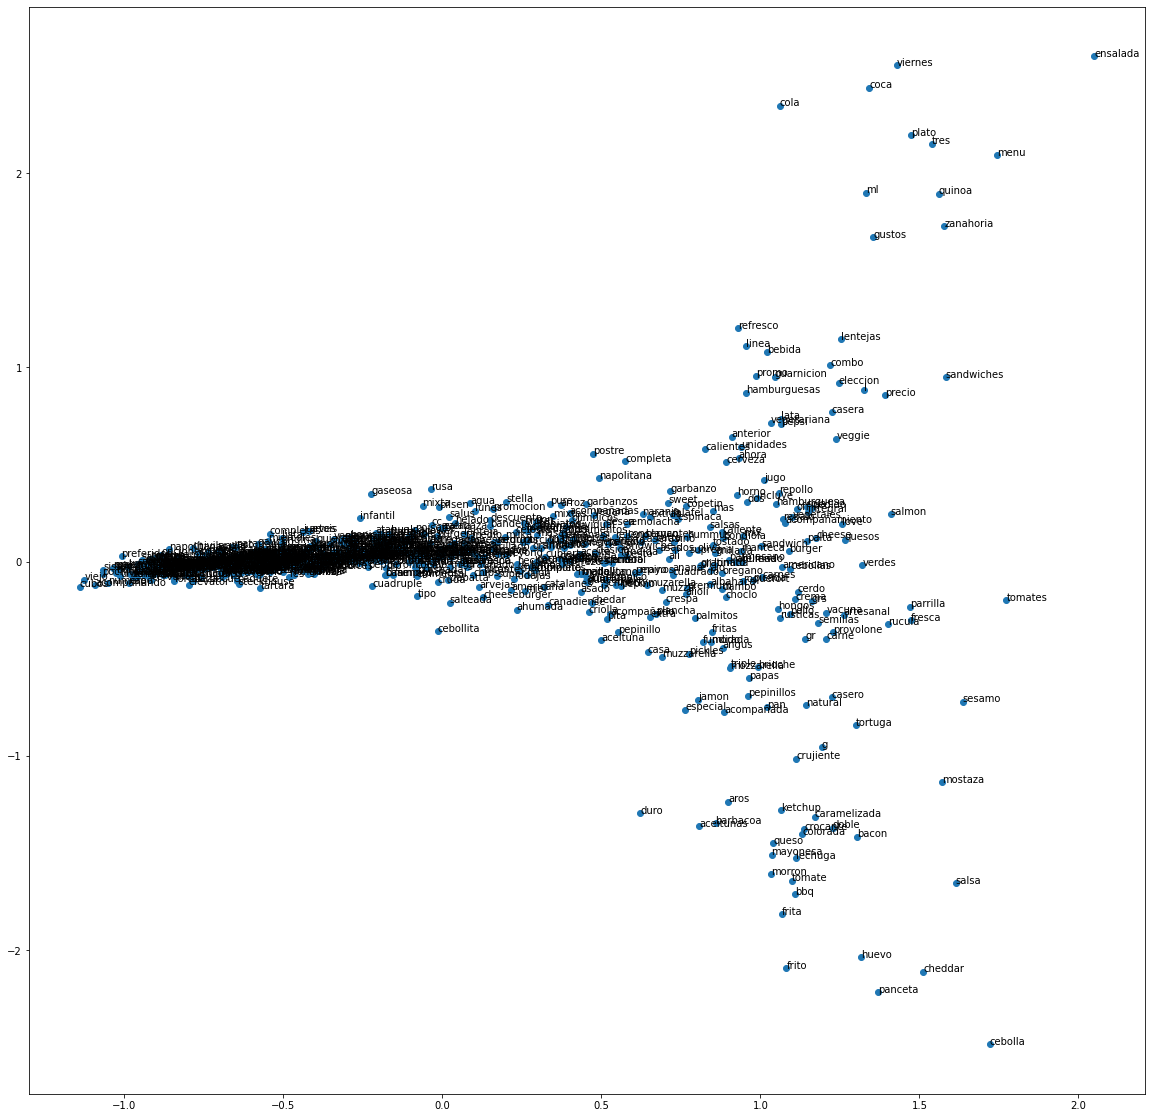

In [65]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.rcParams["figure.figsize"] = (20,20)

pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

In [66]:
from sklearn.manifold import TSNE

In [70]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(model[model.wv.vocab])

/Users/leandro/Documents/facultad/analisis_datos/analisis/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [77]:
df = pd.DataFrame(X_tsne, index=list(model.wv.vocab.keys()), columns=['x', 'y'])
print(df)

                     x          y
hamburguesa -34.137215  17.211643
vegetariana -32.072273  19.815468
garbanzos   -16.646309   6.519862
vegetales   -27.889870  20.853321
lechuga     -14.174409  26.383421
...                ...        ...
harlem       36.671009  10.729967
congelada    37.096874  15.601607
articulo     16.000660 -15.608606
admite       12.785862 -16.955416
cupones      24.249620  -7.032238

[712 rows x 2 columns]


In [84]:
#### Recortamos dataset para mejor visualización

In [85]:
sample = df.sample(n=400)

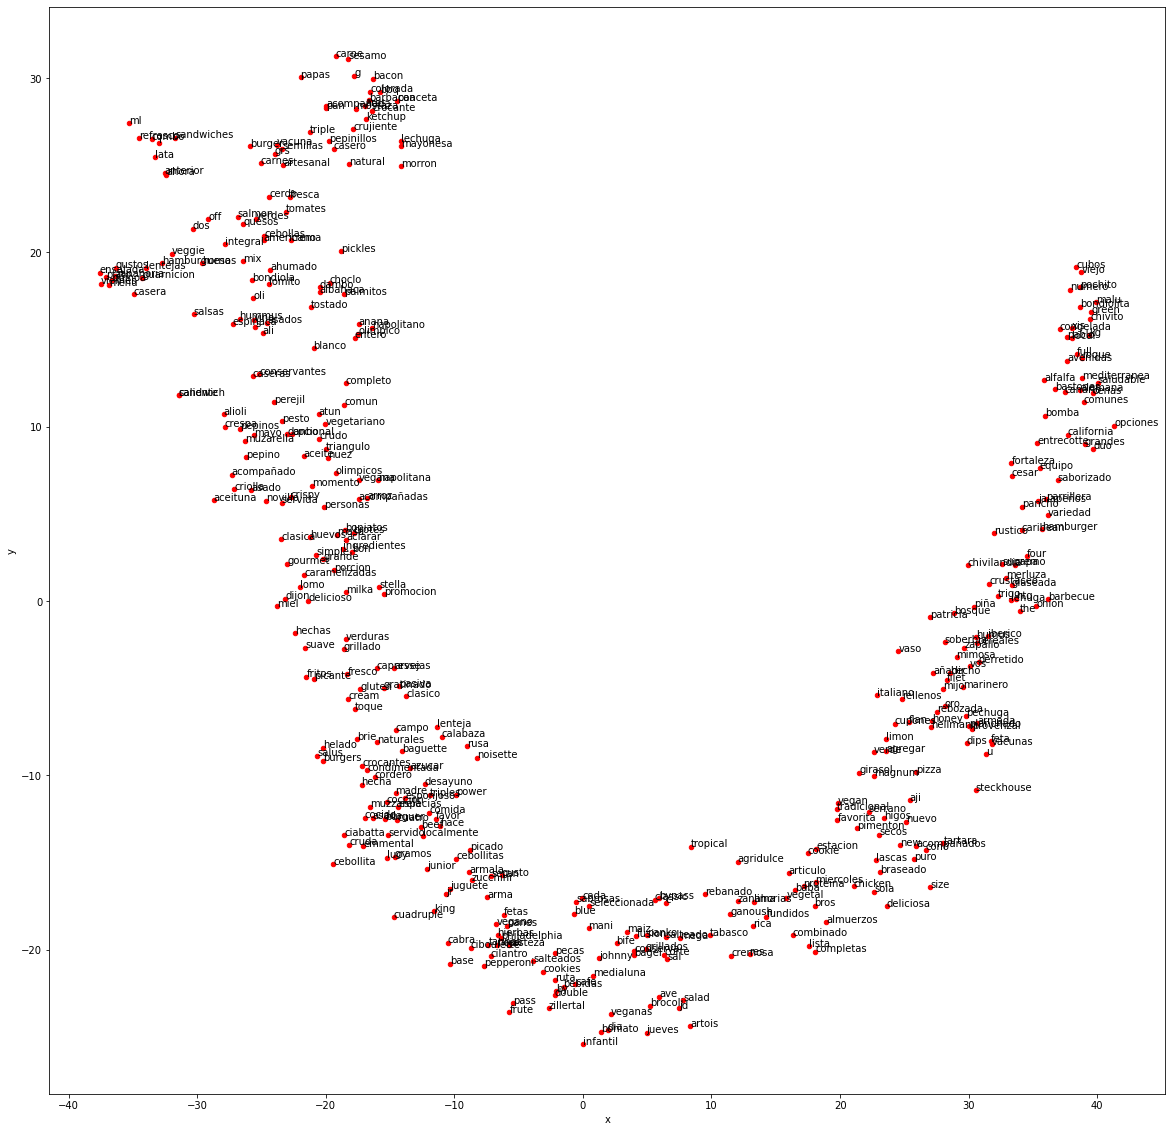

In [86]:
sample.plot(kind='scatter',x='x',y='y',color='red')

for word, row in sample.iterrows():
    pyplot.annotate(word, xy=(row['x'], row['y']))
plt.show()

In [91]:
ms=model.most_similar('carne', topn=10)
ms

/Users/leandro/Documents/facultad/analisis_datos/analisis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sesamo', 0.9600954055786133),
 ('tortuga', 0.9568241238594055),
 ('hamburguesa', 0.9529680609703064),
 ('g', 0.945533037185669),
 ('gr', 0.9399780631065369),
 ('doble', 0.935128927230835),
 ('pan', 0.9205542802810669),
 ('triple', 0.9180355072021484),
 ('vacuna', 0.9050193428993225),
 ('rusticas', 0.9042954444885254)]

In [92]:
ms=model.most_similar('coca', topn=10)
ms

/Users/leandro/Documents/facultad/analisis_datos/analisis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cola', 0.9869568347930908),
 ('ml', 0.9862779378890991),
 ('refresco', 0.9601992964744568),
 ('linea', 0.9406207799911499),
 ('promo', 0.9058400392532349),
 ('bebida', 0.8970184922218323),
 ('combo', 0.8926950693130493),
 ('gaseosa', 0.8851674795150757),
 ('lata', 0.8719903826713562),
 ('l', 0.8646464347839355)]

In [93]:
ms=model.most_similar('lechuga', topn=10)
ms

/Users/leandro/Documents/facultad/analisis_datos/analisis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mayonesa', 0.9967533349990845),
 ('huevo', 0.9859421849250793),
 ('frito', 0.9811049103736877),
 ('tomate', 0.9687212109565735),
 ('ketchup', 0.9610647559165955),
 ('acompañada', 0.9602220058441162),
 ('frita', 0.9550402760505676),
 ('morron', 0.9544640183448792),
 ('panceta', 0.9514247179031372),
 ('acompañando', 0.9506723284721375)]

In [97]:
ms=model.most_similar('naturales', topn=10)
ms

/Users/leandro/Documents/facultad/analisis_datos/analisis/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('momento', 0.9994388818740845),
 ('gluten', 0.9993658661842346),
 ('esponjoso', 0.9993126392364502),
 ('vegano', 0.9992672801017761),
 ('batta', 0.9992102384567261),
 ('pastrami', 0.9991846084594727),
 ('panes', 0.9991557598114014),
 ('corteza', 0.9991551637649536),
 ('vegetales', 0.9991340637207031),
 ('fetas', 0.9991323351860046)]